<a href="https://colab.research.google.com/github/Aliounegahn/Machine-Learning-Projects/blob/master/M2SID_TP1_GAHN_Alioune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2 SID TP1 audio : Détection audio Homme/Femme 

**NOM** : GAHN

**Prénom** : Alioune Badara Ba

**Email** : alioune-badara-ba.gahn@univ-tlse3.fr

---

Utilisation de MFCC pour faire une detection Homme/Femme à partir d'une modélisation par modèles de mélanges de Gaussiennes (GMM). Basé sur la page [blog](https://appliedmachinelearning.blog/2017/06/14/voice-gender-detection-using-gmms-a-python-primer/).

In [1]:
# OS setup
!cat /etc/os-release
!apt-get install -qq bc tree sox

!pip install python_speech_features

import os
import numpy as np
from scipy.io.wavfile import read
from sklearn import mixture
import python_speech_features as mfcc
from sklearn import preprocessing
import warnings
import pickle
from IPython.display import Audio
warnings.filterwarnings("ignore")

# Liaison avec les données
!git clone https://gitlab.com/jeromefarinas/tp-m2-sid.git

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
Selecting previously unselected package libopencore-amrnb0:amd64.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../0-libopencore-amrnb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../1-libopencore-amrwb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libmagic-mgc.
Preparing to unpack .../2-libmagic-mgc_1%3a5.32-2ubuntu0.2_amd64.deb ...
Unpacking libmagic-mgc (1:5.32-2ubuntu0.2)

In [0]:
# chemin où sauvegarder les modèles
chemin_modeles = '/content/tp-m2-sid/modeles/'
# chemin vers données d'apprentissage
chemin_train   = '/content/tp-m2-sid/corpus/train_data/youtube/'
# chemin vers les données de test
chemin_test    = '/content/tp-m2-sid/corpus/test_data/AudioSet/'

Données :
1. Le corpus d'entrainement : Il a été développé à partir de vidéos YouTube et se compose de 5 minutes de discours pour chaque sexe, prononcé par 5 orateurs et 5 oratrices distincts (c.-à-d. 1 minute/orateur).

2. Le corpus de tests : a été extrait de [AudioSet](https://research.google.com/audioset/), un corpus annoté manuellement à grande échelle récemment publié par Google en 2017. Le sous-ensemble construit ici contient 558 énoncés vocaux féminins seulement et 546 énoncés vocaux masculins seulement. Tous les fichiers audio ont une durée de 10 secondes et sont échantillonnés à 16000 Hz.


In [3]:
!tree -L 1 /content/tp-m2-sid/corpus/

/content/tp-m2-sid/corpus/
├── development_set
├── test_data
├── train_data
└── voyelles

4 directories, 0 files


###1. Extraction de MFCC

Vous utiliserez la fonction ci-dessous pour calculer des paramètres MFCC.

In [0]:
def get_MFCC(sr,audio):
    features = mfcc.mfcc(audio,sr, 0.025, 0.01, 13,appendEnergy = False)
    feat     = np.asarray(())
    for i in range(features.shape[0]):
        temp = features[i,:]
        if np.isnan(np.min(temp)):
            continue
        else:
            if feat.size == 0:
                feat = temp
            else:
                feat = np.vstack((feat, temp))
    features = feat;
    features = preprocessing.scale(features)
    return features

Lecture audio d'un fichier au hasard :

In [5]:
fech,audio = read('/content/tp-m2-sid/corpus/test_data/AudioSet/female_clips/178NyD2I37s.wav')
Audio(audio, rate=fech)

***A faire :***
1. ***Affichez le signal.***
2. ***Affichez le spectrogramme associé***
3. ***Calculez la matrice MFCC et affichez la.***

Affichons le signal

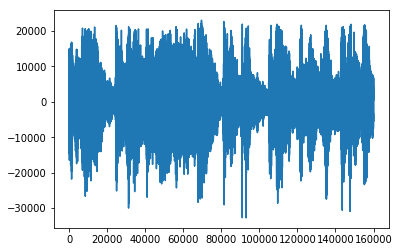

In [6]:
import matplotlib.pyplot as plt
plt.plot(audio)

affichons le spectrogramme associé

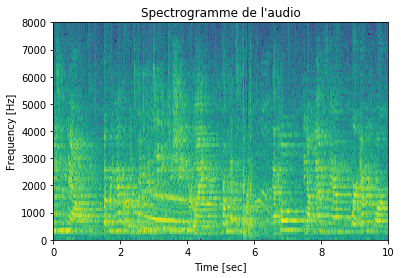

In [7]:
from scipy import signal
frequencies, times, spectrogram = signal.spectrogram(audio,fech,'hamming')

plt.pcolormesh(times, frequencies, np.log(spectrogram))
plt.title("Spectrogramme de l'audio")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

calculer le mfcc et affichons la

In [0]:
mfcc1 = get_MFCC(fech,audio)

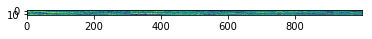

In [9]:
plt.imshow(np.transpose(mfcc1))

###2. Apprentissage des modèles de genre

Le paquet [sklearn.mixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) de Python va nous permettre d'apprendre un GMM à partir de la matrice de parametres MFCC. L'objet **GMM** nécessite de définir le nombre de composantes à utiliser : **n_components** à ajuster sur les données, le nombre maximum d'itérations **max_iter** à effectuer pour estimer les paramètres de ces n composantes, le type de covariance **covariance_type** à utiliser, le nombre de fois **n_init** où l'initialisation K-means doit être effectuée. L'initialisation qui a donné les meilleurs résultats est conservée. La fonction **fit()** estime ensuite les paramètres du modèle à l'aide de l'algorithme EM.

In [0]:
files    = [os.path.join(chemin_train + 'male',f) for f in os.listdir(chemin_train + 'male') if
             f.endswith('.wav')]
features = np.asarray(());
 
for f in files:
    fech,audio = read(f)
    vector   = get_MFCC(fech,audio)
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
 
gmm = mixture.GaussianMixture(n_components = 8, max_iter = 200, covariance_type='diag', n_init = 3)
gmm.fit(features)
 
# enregistrement du modèle comme male.gmm
gmmfile = open(chemin_modeles + 'male' + '.gmm','wb')
pickle.dump(gmm,gmmfile)
print('enregistrement terminé pour male.gmm')

enregistrement terminé pour male.gmm


***A faire :***
1. ***Completez ce code pour générer le modèle féminin***
2. ***Après avoir fait la partie 3, faites varier les paramètres lors de la création GMM. Créez plusieurs versions de modèles (dans de nouveaux dossiers modeles).***

Modèle féminin

In [0]:
files    = [os.path.join(chemin_train + 'female',f) for f in os.listdir(chemin_train + 'female') if
             f.endswith('.wav')]
features = np.asarray(());
 
for f in files:
    fech,audio = read(f)
    vector   = get_MFCC(fech,audio)
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
 
gmm = mixture.GaussianMixture(n_components = 8, max_iter = 200, covariance_type='diag', n_init = 3)
gmm.fit(features)
 
# enregistrement du modèle comme male.gmm
gmmfile = open(chemin_modeles + 'female' + '.gmm','wb')
pickle.dump(gmm,gmmfile)
print('enregistrement terminé pour female.gmm')

enregistrement terminé pour female.gmm


In [0]:
!ls /content/tp-m2-sid/modeles/

female.gmm  male.gmm  README.md


###3. Evaluation des modèles

In [0]:
vf = 0 
ff = 0
gmm_files = [os.path.join(chemin_modeles,fname) for fname in
              os.listdir(chemin_modeles) if fname.endswith('.gmm')]
models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
genders   = [fname.split("/")[-1].split(".gmm")[0] for fname
              in gmm_files]
files     = [os.path.join(chemin_test + 'female_clips/',f) for f in os.listdir(chemin_test + 'female_clips/')
              if f.endswith(".wav")] 
print(genders)
for f in files:
    print(f.split("/")[-1])
    fech, audio  = read(f)
    features   = get_MFCC(fech,audio)
    scores     = None
    log_likelihood = np.zeros(len(models))
    for i in range(len(models)):
        gmm    = models[i]         #passage en revue des modeles un par un
        scores = np.array(gmm.score(features))
        log_likelihood[i] = scores.sum()
    winner = np.argmax(log_likelihood)
    if genders[winner] == 'female':
      vf = vf + 1
    else:
      ff = ff + 1
    print("\tdétecté comme - ", genders[winner],"\n\tscores: femme ",log_likelihood[0],",homme ", log_likelihood[1],"\n")


['female', 'male']
4rSIgRMjMqo.wav
	détecté comme -  female 
	scores: femme  -18.404848447957303 ,homme  -19.102807096016633 

2jR4V4WS-pI.wav
	détecté comme -  female 
	scores: femme  -17.421572285317005 ,homme  -18.255844619741566 

0evZIW8vwDI.wav
	détecté comme -  female 
	scores: femme  -18.970296448575862 ,homme  -19.373005177293187 

-elLA6vzAig.wav
	détecté comme -  female 
	scores: femme  -18.495731729646852 ,homme  -19.168696910014184 

4lBTenfUFoU.wav
	détecté comme -  female 
	scores: femme  -18.290058066217213 ,homme  -18.977527262243044 

2nF6fL0h0qM.wav
	détecté comme -  female 
	scores: femme  -17.598470479529606 ,homme  -18.36408018481886 

3qRHsNnPpHo.wav
	détecté comme -  female 
	scores: femme  -17.53859691216138 ,homme  -18.285545459615825 

0bIb6Pjzk1g.wav
	détecté comme -  female 
	scores: femme  -18.28649598181178 ,homme  -19.442599613615876 

2F0Sqy2va40.wav
	détecté comme -  female 
	scores: femme  -17.414972468175893 ,homme  -18.283452223800914 

1F8kDtgfsBs.

***A faire : ***
1. ***Ajoutez les tests sur les hommes***
2. ***Affichez la matrice de confusion***
3. ***intégrez les différents modèles calculés et créez des graphiques pour représenter ces résultats. Quels sont les meilleurs résultats obtenus ?***

Tests sur les hommes

In [0]:
vh = 0 
fh = 0 
gmm_files = [os.path.join(chemin_modeles,fname) for fname in
              os.listdir(chemin_modeles) if fname.endswith('.gmm')]
models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
genders   = [fname.split("/")[-1].split(".gmm")[0] for fname
              in gmm_files]
files     = [os.path.join(chemin_test + 'male_clips/',f) for f in os.listdir(chemin_test + 'male_clips/')
              if f.endswith(".wav")] 
print(genders)
for f in files:
    print(f.split("/")[-1])
    fech, audio  = read(f)
    features   = get_MFCC(fech,audio)
    scores     = None
    log_likelihood = np.zeros(len(models))
    for i in range(len(models)):
        gmm    = models[i]         #passage en revue des modeles un par un
        scores = np.array(gmm.score(features))
        log_likelihood[i] = scores.sum()
    winnerh = np.argmax(log_likelihood)
    if genders[winnerh] == 'male':
      vh = vh + 1
    else:
      fh = fh + 1
    print("\tdétecté comme - ", genders[winnerh],"\n\tscores: femme ",log_likelihood[0],",homme ", log_likelihood[1],"\n")

['female', 'male']
0O73b0VBytI.wav
	détecté comme -  male 
	scores: femme  -19.161762901470034 ,homme  -18.92019936624815 

1g53wmFxOxc.wav
	détecté comme -  male 
	scores: femme  -18.639215829474544 ,homme  -18.23923228295512 

3GC_BomLN6g.wav
	détecté comme -  male 
	scores: femme  -16.985370512085005 ,homme  -16.72627826246262 

0KhyNyCv2Fs.wav
	détecté comme -  male 
	scores: femme  -19.603750024047724 ,homme  -19.230004424185303 

0EJFXZmK4LM.wav
	détecté comme -  male 
	scores: femme  -19.280879934030093 ,homme  -19.212111195844948 

1Bj6Kpd91TI.wav
	détecté comme -  female 
	scores: femme  -20.08793593229189 ,homme  -20.273226843782403 

0dbXYJGN2-4.wav
	détecté comme -  male 
	scores: femme  -18.89343383967807 ,homme  -18.459694982649793 

1nVA5qrdD18.wav
	détecté comme -  male 
	scores: femme  -18.840537377811017 ,homme  -18.767164676455927 

0aPGq3ovKCI.wav
	détecté comme -  male 
	scores: femme  -17.89380179382253 ,homme  -17.389848835654497 

0IZKgWhfhh4.wav
	détecté comme 

Affichons la matrice de confusion correspondante

In [0]:
import pandas as pd
dic = {'real_homme': [vh,fh], 'real_femme':[ff,vf]}
mc = pd.DataFrame.from_dict(dic, orient = 'index', columns = ['pred_homme','pred_femme'])
mc

,pred_homme,pred_femme
real_homme,415,131
real_femme,28,530


**Pour observer les meilleurs parametres, mettons tout ca en fonctions comme ca nous ne faisons qu'un appel pour analyser nos résultats**

In [0]:
def testhomme():
  vh = 0 
  fh = 0 
  count = 0
  gmm_files = [os.path.join(chemin_modeles,fname) for fname in
                os.listdir(chemin_modeles) if fname.endswith('.gmm')]
  models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
  genders   = [fname.split("/")[-1].split(".gmm")[0] for fname
                in gmm_files]
  files     = [os.path.join(chemin_test + 'male_clips/',f) for f in os.listdir(chemin_test + 'male_clips/')
                if f.endswith(".wav")] 
  print(genders)
  for f in files:
      count = count + 1
      fech, audio  = read(f)
      features   = get_MFCC(fech,audio)
      scores     = None
      log_likelihood = np.zeros(len(models))
      for i in range(len(models)):
          gmm    = models[i]         #passage en revue des modeles un par un
          scores = np.array(gmm.score(features))
          log_likelihood[i] = scores.sum()
      winnerh = np.argmax(log_likelihood)
      if genders[winnerh] == 'male':
        vh = vh + 1
      else:
        fh = fh + 1
  return(fh, count,vh)

In [0]:
def testfemme():
  vf = 0 
  ff = 0
  count = 0
  gmm_files = [os.path.join(chemin_modeles,fname) for fname in
                os.listdir(chemin_modeles) if fname.endswith('.gmm')]
  models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
  genders   = [fname.split("/")[-1].split(".gmm")[0] for fname
                in gmm_files]
  files     = [os.path.join(chemin_test + 'female_clips/',f) for f in os.listdir(chemin_test + 'female_clips/')
                if f.endswith(".wav")] 
  print(genders)
  for f in files:
      count = count + 1
      fech, audio  = read(f)
      features   = get_MFCC(fech,audio)
      scores     = None
      log_likelihood = np.zeros(len(models))
      for i in range(len(models)):
          gmm    = models[i]         #passage en revue des modeles un par un
          scores = np.array(gmm.score(features))
          log_likelihood[i] = scores.sum()
      winner = np.argmax(log_likelihood)
      if genders[winner] == 'female':
        vf = vf + 1
      else:
        ff = ff + 1
  return(ff,count,vf)

In [0]:
def modfm (nc , mi , ct, ni ):
  files    = [os.path.join(chemin_train + 'female',f) for f in os.listdir(chemin_train + 'female') if
               f.endswith('.wav')]
  features = np.asarray(());

  for f in files:
      fech,audio = read(f)
      vector   = get_MFCC(fech,audio)
      if features.size == 0:
          features = vector
      else:
          features = np.vstack((features, vector))

  gmm = mixture.GaussianMixture(n_components = nc, max_iter = mi, covariance_type=ct, n_init = ni)
  gmm.fit(features)

  # enregistrement du modèle comme male.gmm
  gmmfile = open(chemin_modeles + 'female' + '.gmm','wb')
  pickle.dump(gmm,gmmfile)
  print('enregistrement terminé pour female.gmm')

In [0]:
def modhm (nc , mi , ct, ni ):
  files    = [os.path.join(chemin_train + 'male',f) for f in os.listdir(chemin_train + 'male') if
               f.endswith('.wav')]
  features = np.asarray(());

  for f in files:
      fech,audio = read(f)
      vector   = get_MFCC(fech,audio)
      if features.size == 0:
          features = vector
      else:
          features = np.vstack((features, vector))

  gmm = mixture.GaussianMixture(n_components = nc, max_iter = mi, covariance_type=ct, n_init = ni)
  gmm.fit(features)

  # enregistrement du modèle comme male.gmm
  gmmfile = open(chemin_modeles + 'male' + '.gmm','wb')
  pickle.dump(gmm,gmmfile)
  print('enregistrement terminé pour male.gmm')

In [0]:
def modelize (nc , mi , ct, ni ):
  modhm(nc , mi , ct, ni)
  modfm(nc , mi , ct, ni)
  accuracy = 1 - ((testfemme()[0]+ testhomme()[0] )/(testfemme()[1]+ testhomme()[1] ))
  return  (accuracy)
  

In [15]:
liste = [modelize(nc , 200, 'diag', 3) for nc in range(1, 10)]

enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'fe

In [20]:
liste

[0.4945652173913043,
 0.7119565217391304,
 0.8713768115942029,
 0.8786231884057971,
 0.8813405797101449,
 0.8514492753623188,
 0.848731884057971,
 0.8233695652173914,
 0.832427536231884]

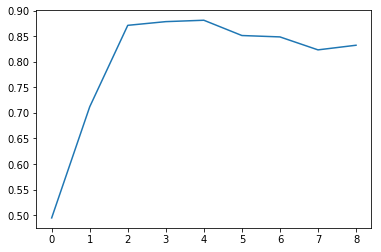

In [19]:
plt.plot(range(9),liste)

Le graphe suivant nous montre que l'accuracy maximale est obtenue en un nombre de centre de cluster = 4. Ce qui veut dire qu'il faut approximer la distribution des données par 4 gaussiennes pour maximiser l'accuracy 

Maintenant regardons pour quelles valeurs nous oobservons les meilleurs precision, recall et F1-Score

In [0]:
## Precision
def modelize1 (nc , mi , ct, ni ):
  modhm(nc , mi , ct, ni)
  modfm(nc , mi , ct, ni)
  precision = ( testhomme()[2] )/(testhomme()[0]+ testhomme()[2] )
  return  (precision)

In [0]:
## Recall
def modelize2 (nc , mi , ct, ni ):
  modhm(nc , mi , ct, ni)
  modfm(nc , mi , ct, ni)
  recal = ( testhomme()[2] )/(testfemme()[0]+ testhomme()[2] )
  return  (recal)

In [26]:
precision = [modelize1(nc , 200, 'diag', 3) for nc in range(1, 10)]

enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour fema

In [28]:
precision

[0.575091575091575,
 0.7527472527472527,
 0.8186813186813187,
 0.8315018315018315,
 0.8241758241758241,
 0.7838827838827839,
 0.7509157509157509,
 0.706959706959707,
 0.7051282051282052]

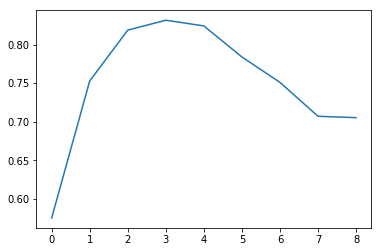

In [30]:
plt.plot(range(9),precision)

La courbe nous dit qu'on a une meilleure precision lorsqu'on a 4 Gaussiennes

In [27]:
recal = [modelize2(nc , 200, 'diag', 3) for nc in range(1, 10)]

enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour female.gmm
['male', 'female']
['male', 'female']
['male', 'female']
enregistrement terminé pour male.gmm
enregistrement terminé pour fema

In [29]:
recal

[0.490625,
 0.7385321100917431,
 0.9122448979591836,
 0.9153225806451613,
 0.9276859504132231,
 0.8991596638655462,
 0.9298642533936652,
 0.9485981308411215,
 0.9360189573459715]

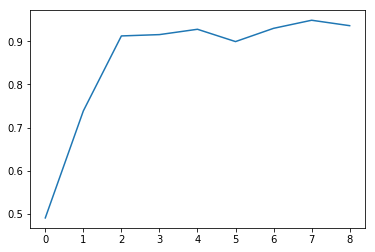

In [31]:
plt.plot(range(9),recal)

La courbe nous montre que la meilleure valeur obtenue pour le recal est lorsqu'on a 7 Gaussiennes

**Calculons maintenant le F1 Score**

In [0]:
f1 = 2*((np.array(precision)*np.array(recal))/(np.array(precision)+np.array(recal)))

In [76]:
f1

array([0.52951096, 0.74557193, 0.86293436, 0.87140115, 0.8728729 ,
       0.83757339, 0.8308639 , 0.81014464, 0.80433173])

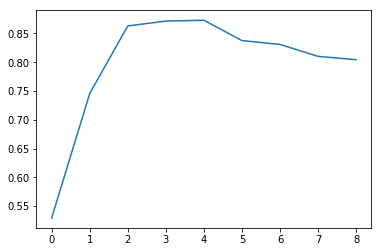

In [77]:
plt.plot(range(9),f1)

La courbe nous montre qu'on observe un meilleur F1-Score lorsque le nombre de Gaussiennes vaut 4 

***Questions :***
1. ***La detection du genre a été réalisé avec des MFCC. Aurait-on pu ajouter d'autres paramètres pour faire cette modélisation ? Lesquels ?***
2. ***Serait-il possible d'afficher une représentation graphique des GMM ? Comment ?***
3. ***Testez les modèles avec un fichier enregistré de votre voix***

1) Oui on aurait pu utiliser d'autres paramètres en sus du MFCC comme la fréquence fondamentale, l'écart type entre les valeurs des vecteurs mfcc etc. Dans ce cas, il suffirait de mettre ces valeurs dans le vecteur features dans le code de création des modèles

2) Oui il serait aussi possible d'afficher une représentation des GMM en faisant un clustering en k classes correspondantes au nombre de gaussiennes choisies. Et faire une acp les données de chaque cluster pour avoir la représentation en deux dimensions. 

3) Testons le modèle avec un fichier enregistré de notre voix: 

In [71]:
# pour rajouter un fichier
from google.colab import files
uploaded = files.upload()


Saving abghn.wav to abghn.wav


In [72]:
files    = [os.path.join(chemin_train + 'male',f) for f in os.listdir(chemin_train + 'male') if
             f.endswith('.wav')]
features = np.asarray(());
 
for f in files:
    fech,audio = read(f)
    vector   = get_MFCC(fech,audio)
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
 
gmm = mixture.GaussianMixture(n_components = 8, max_iter = 200, covariance_type='diag', n_init = 3)
gmm.fit(features)
 
# enregistrement du modèle comme male.gmm
gmmfile = open(chemin_modeles + 'male' + '.gmm','wb')
pickle.dump(gmm,gmmfile)
print('enregistrement terminé pour male.gmm')

enregistrement terminé pour male.gmm


In [73]:
files    = [os.path.join(chemin_train + 'female',f) for f in os.listdir(chemin_train + 'female') if
             f.endswith('.wav')]
features = np.asarray(());
 
for f in files:
    fech,audio = read(f)
    vector   = get_MFCC(fech,audio)
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
 
gmm = mixture.GaussianMixture(n_components = 8, max_iter = 200, covariance_type='diag', n_init = 3)
gmm.fit(features)
 
# enregistrement du modèle comme male.gmm
gmmfile = open(chemin_modeles + 'female' + '.gmm','wb')
pickle.dump(gmm,gmmfile)
print('enregistrement terminé pour female.gmm')

enregistrement terminé pour female.gmm


In [74]:
fech1,audio = read('abghn.wav')
gmm_files = [os.path.join(chemin_modeles,fname) for fname in
          os.listdir(chemin_modeles) if fname.endswith('.gmm')]
models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
genders   = [fname.split("/")[-1].split(".gmm")[0] for fname in gmm_files]
features   = get_MFCC(fech1,audio)
scores     = None
log_likelihood = np.zeros(len(models))
for i in range(len(models)):
    gmm    = models[i]         #passage en revue des modeles un par un
    scores = np.array(gmm.score(features))
    log_likelihood[i] = scores.sum()
winnerh = np.argmax(log_likelihood)

print("\tdétecté comme - ", genders[winner],"\n\tscores: femme ",log_likelihood[0],",homme ", log_likelihood[1],"\n")


	détecté comme -  female 
	scores: femme  -20.037429239941158 ,homme  -19.671745847209493 



Le modèle detecte une voix de femme